# VVIX ZScore Model

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\VIXCurveStrategies\root\src")
from VVIXZscoreStrats import VVIXZscoreStrats
from BackgroundFunction import BackgroundFunctions

In [3]:
def get_rtn() -> pd.DataFrame: 
    
    df_out = (VVIXZscoreStrats().get_zscore().assign(
        group_var = lambda x: "Short: " +  x.short_leg + " ZScore Window: " + x.window.astype(str) + "d").
        drop(columns = ["lag_zscore"]).
        rename(columns = {"window": "param"}))
    
    return df_out

df = get_rtn()

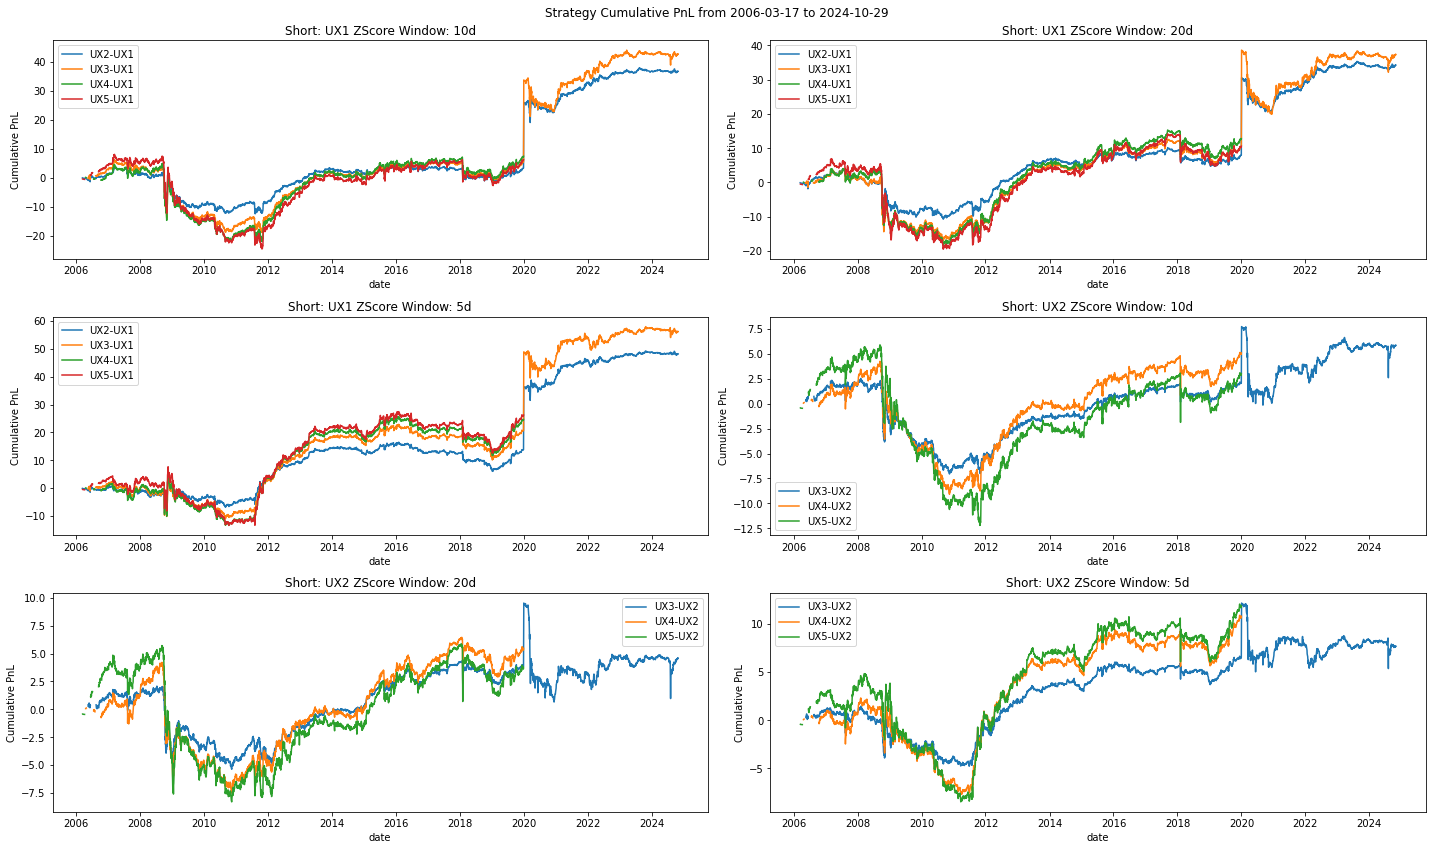

In [4]:
BackgroundFunctions().plot_backtest_rtn(df)

In [5]:
def get_sharpe(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_grouper = df[["strat", "short_leg"]].drop_duplicates()

    df_out = (df[
        ["date", "param", "strat", "spread", "signal_spread"]].
        melt(id_vars = ["date", "param", "strat"]).
        drop(columns = ["date"]).
        groupby(["param", "strat", "variable"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index().
        drop(columns = ["mean_rtn", "std_rtn"]).
        pivot(index = ["param", "strat"], columns = "variable", values = "sharpe").
        reset_index().
        assign(param = lambda x: x.param.astype(str) + "d").
        pivot(index = ["strat", "spread"], columns = "param", values = "signal_spread").
        reset_index().
        merge(right = df_grouper, how = "inner", on = ["strat"]).
        rename(columns = {"spread": "None"}))
    
    return df_out

df_sharpe = get_sharpe(df)

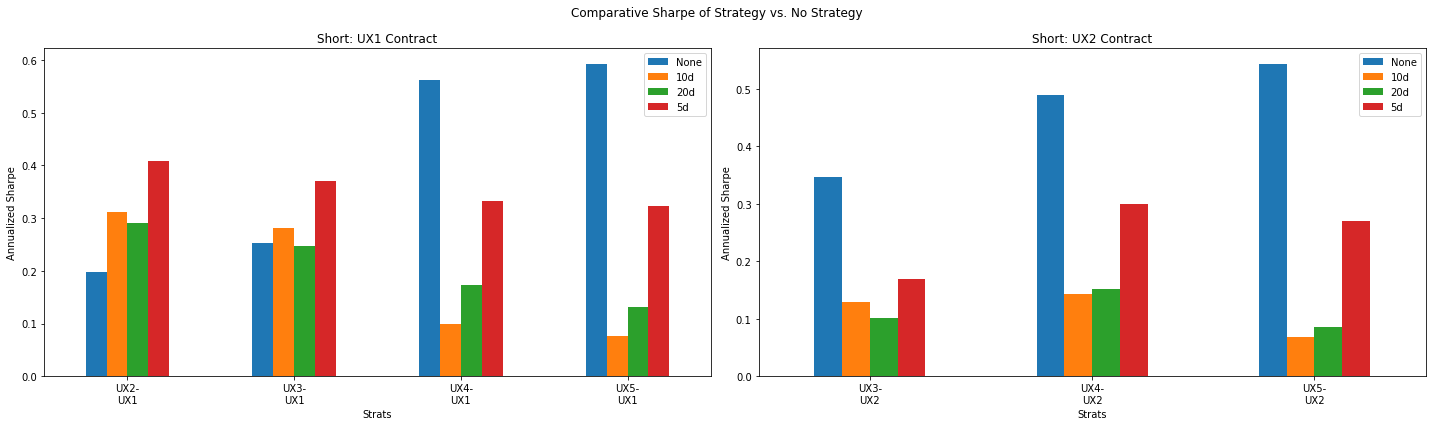

In [6]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    group_vars = df_sharpe.short_leg.drop_duplicates().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars), figsize = (20,6))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        (df_sharpe.query(
            "short_leg == @group_var").
            drop(columns = ["short_leg"]).
            assign(strat = lambda x: x.strat.str.replace("-", "-\n")).
            set_index("strat").
            plot(
                ax   = ax,
                kind = "bar",
                ylabel = "Annualized Sharpe",
                xlabel = "Strats",
                title  = "Short: {} Contract".format(group_var)))

        ax.tick_params(axis = "x", rotation = 0)

    fig.suptitle("Comparative Sharpe of Strategy vs. No Strategy")
    plt.tight_layout()
    
plot_sharpe(df_sharpe)